Loss Value at Epoch 300 => 0.008938: 100%|██████████| 300/300 [00:18<00:00, 15.94it/s]


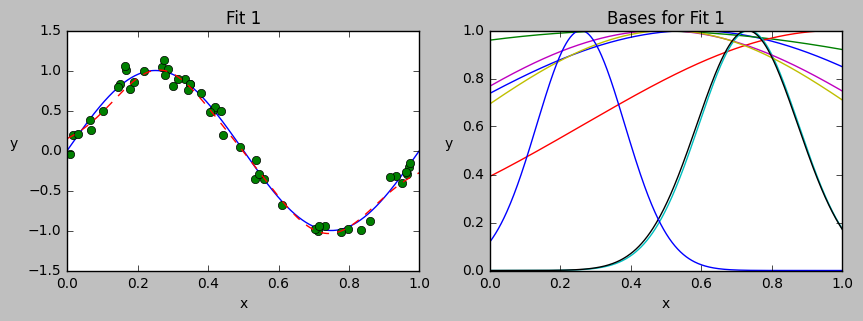

In [31]:
# Danny Hong
# ECE 472 - Deep Learning
# Assignment 1

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from absl import app
from absl import flags
from tqdm import trange
 
from scipy.stats import norm
from dataclasses import dataclass, field, InitVar

@dataclass
class Data:

  rng: InitVar[np.random.Generator]
  num_features: int
  num_samples: int
  sigma: float
  x: np.ndarray = field(init = False)
  y: np.ndarray = field(init = False)

  def __post_init__(self, rng):
    self.index = np.arange(num_samples)
    self.x = rng.uniform(low = 0, high = 1, size = (self.num_samples, self.num_features))
    clean_y = np.sin(np.pi * 2 * self.x)
    self.y = rng.normal(loc = clean_y, scale = sigma_noise)

  def get_batch(self, rng, batch_size):
    """Select random subset of examples for training batch"""
    choices = rng.choice(self.index, size = batch_size)
    return self.x[choices].flatten(), self.y[choices].flatten()

class Model(tf.Module):

  def __init__(self, rng, num_features, M):
    self.num_features = num_features
    self.M = M
    self.w = tf.Variable(rng.normal(shape = [self.M, 1]), name = 'w')
    self.mu =  tf.Variable(rng.uniform(minval = 0, maxval = 1, shape = [self.M, 1]), name = 'mu')
    self.sigma = tf.Variable(tf.random.normal(shape = [self.M, 1]), name = 'sigma')
    self.b = tf.Variable(tf.zeros(shape = [1, 1]), name = 'b')   

  def f(self, x):
    y_hat = np.zeros_like(x)
    for i in range(self.M):
      phi = tf.exp(-(x - self.mu[i]) ** 2 / self.sigma[i] ** 2)
      y_hat += (self.w[i] * phi)

    y_hat = tf.squeeze(y_hat + self.b)
    return y_hat

def loss_function(y_hat, y):
  loss = 0.5 * tf.reduce_mean((y_hat - y) ** 2)
  return loss

def phi_function(xs, mu, sigma):
  phi = tf.exp(-((xs - mu) ** 2) / (sigma ** 2)).numpy()
  return phi

num_samples = 50 
num_features = 1
M = 8
batch_size = 16
num_iters = 300
sigma_noise = 0.1
random_seed = np.random.seed(31415)

def main():

  seed_sequence = np.random.SeedSequence(random_seed)
  np_seed, tf_seed = seed_sequence.spawn(2)
  np_rng = np.random.default_rng(np_seed)
  tf_rng = tf.random.Generator.from_seed(tf_seed.entropy)

  data = Data(np_rng, num_features, num_samples, sigma_noise)
  model = Model(tf_rng, num_features, M)

  optimizer = tf.optimizers.SGD(learning_rate = 0.1)

  bar = trange(num_iters)
  for j in bar:
    with tf.GradientTape() as tape:
      x, y = data.get_batch(np_rng, batch_size)
      y_hat = model.f(x)
      loss = loss_function(y_hat, y)

    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    bar.set_description(f"Loss Value at Epoch {j + 1} => {loss.numpy():0.6f}")
    bar.refresh()

  xs = np.linspace(0, 1, 500)
  xs = xs[:, np.newaxis]
  ys = np.sin(2 * np.pi * xs)
  y_predicted = model.f(xs)
  
  fig, ax = plt.subplots(1, 2, figsize = (10, 3), dpi = 100)

  ax[0].set_xlabel('x')
  ax[0].set_ylabel('y', rotation = 0, labelpad = 10)
  ax[0].set_title("Fit 1")

  ax[0].plot(xs, ys, color = 'blue')
  ax[0].plot(np.squeeze(data.x), data.y, "o", color = 'green')
  ax[0].plot(xs, np.squeeze(y_predicted), "--", color = 'red')
  
  ax[1].set_xlabel('x')
  ax[1].set_ylabel('y', rotation = 0, labelpad = 10)
  ax[1].set_title("Bases for Fit 1")

  for i in range(M):
    ax[1].plot(xs, phi_function(xs, model.mu[i], model.sigma[i]))
  
  plt.tight_layout

main()